In [ ]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


In [ ]:
# Download Kaggle dataset
try:
    path = kagglehub.dataset_download("pschale/mlb-pitch-data-20152018")
    print("Dataset downloaded successfully to:", path)
except Exception as e:
    print("Error downloading dataset:", e)
    exit()

# Load the dataset
try:
    dataset_path = f"{path}/games.csv"
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully!")
except Exception as e:
    print("Error loading dataset:", e)
    exit()


100%|██████████| 370M/370M [00:08<00:00, 46.4MB/s]

Extracting files...


Dataset downloaded successfully to: /root/.cache/kagglehub/datasets/pschale/mlb-pitch-data-20152018/versions/2
Dataset loaded successfully!


In [ ]:
# Data Preparation
# Derive the winner (home win, away win, or tie)
df['home_win'] = np.where(df['home_final_score'] > df['away_final_score'], 1, 0)  # 1 if home wins, else 0

# Drop rows with ties if they are not relevant for prediction
df = df[df['home_final_score'] != df['away_final_score']]

# Feature and Target Split
X = df[['home_final_score', 'away_final_score']]  # Features
y = df['home_win']  # Target

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Models to Evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier()
}

# Evaluate Models
model_results = {}

for model_name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardizing data
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    model_results[model_name] = np.mean(scores)

# Best Model Selection
best_model_name = max(model_results, key=model_results.get)
print("Best Model:", best_model_name)
print("Model Performance:", model_results)

# Train the Best Model and Evaluate on Test Set
best_model = models[best_model_name]
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_model)
])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy for Best Model ({best_model_name}): {test_accuracy}")

Best Model: Logistic Regression
Model Performance: {'Logistic Regression': 1.0, 'Random Forest': 1.0, 'Support Vector Machine': 1.0, 'Decision Tree': 1.0}
Test Accuracy for Best Model (Logistic Regression): 1.0


Accuracy: 0.5027352297592997
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.44      0.44       822
           1       0.55      0.56      0.55      1006

    accuracy                           0.50      1828
   macro avg       0.50      0.50      0.50      1828
weighted avg       0.50      0.50      0.50      1828



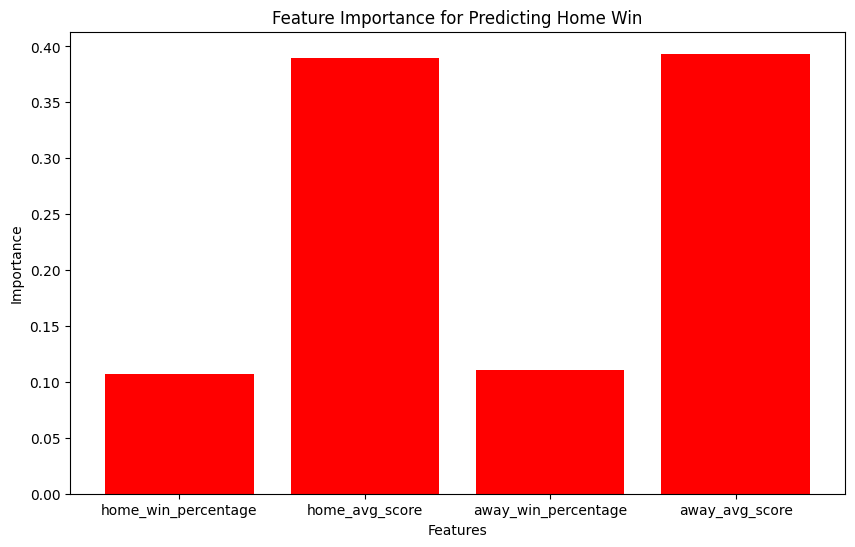

In [ ]:
# Sort the dataset by team and date for calculating recent performance
df['date'] = pd.to_datetime(df['date'])  # Ensure the 'date' column is in datetime format
df = df.sort_values(by='date')

# Helper function to calculate recent game statistics
def calculate_recent_stats(team, date, n=10):
    recent_games = df[((df['home_team'] == team) | (df['away_team'] == team)) & (df['date'] < date)].tail(n)
    wins = ((recent_games['home_team'] == team) & (recent_games['home_win'] == 1)).sum() + \
           ((recent_games['away_team'] == team) & (recent_games['home_win'] == 0)).sum()
    total_games = len(recent_games)
    win_percentage = wins / total_games if total_games > 0 else 0
    avg_score = recent_games.loc[recent_games['home_team'] == team, 'home_final_score'].mean() + \
                recent_games.loc[recent_games['away_team'] == team, 'away_final_score'].mean()
    avg_score /= 2 if total_games > 0 else 1
    return win_percentage, avg_score

# Add features for recent performance
recent_games_count = 10
df['home_win_percentage'] = df.apply(lambda row: calculate_recent_stats(row['home_team'], row['date'], recent_games_count)[0], axis=1)
df['home_avg_score'] = df.apply(lambda row: calculate_recent_stats(row['home_team'], row['date'], recent_games_count)[1], axis=1)
df['away_win_percentage'] = df.apply(lambda row: calculate_recent_stats(row['away_team'], row['date'], recent_games_count)[0], axis=1)
df['away_avg_score'] = df.apply(lambda row: calculate_recent_stats(row['away_team'], row['date'], recent_games_count)[1], axis=1)

# Drop rows with missing data due to insufficient recent games
df = df.dropna()

# Features and Target
X = df[['home_win_percentage', 'home_avg_score', 'away_win_percentage', 'away_avg_score']]
y = df['home_win']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection
model = RandomForestClassifier(random_state=42)

# Training the Model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
])
pipeline.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualization: Feature Importance
importance = model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.bar(features, importance, color='red')
plt.title('Feature Importance for Predicting Home Win')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

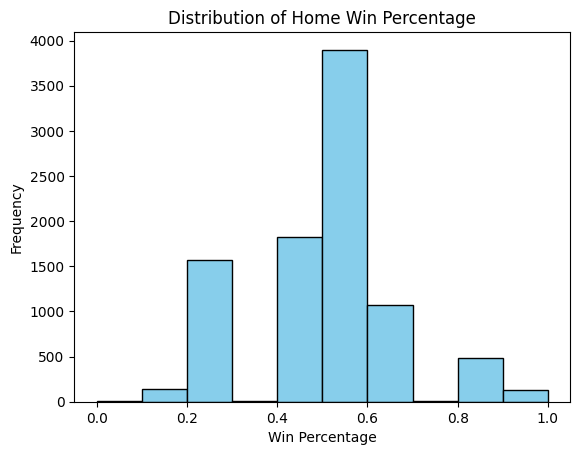

In [ ]:
import matplotlib.pyplot as plt

# Histogram for home win percentage
plt.hist(df['home_win_percentage'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Home Win Percentage')
plt.xlabel('Win Percentage')
plt.ylabel('Frequency')
plt.show()

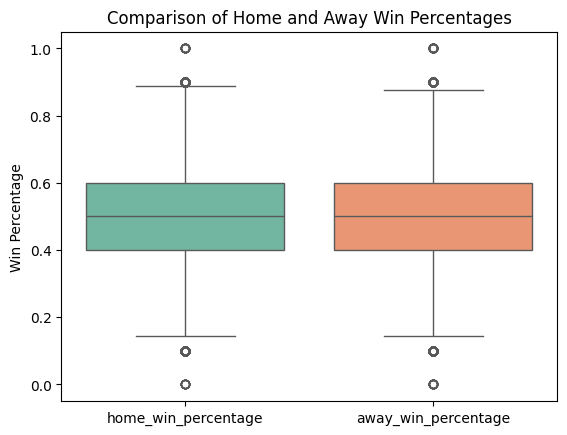

In [ ]:
import seaborn as sns

# Box plot for home and away win percentages
sns.boxplot(data=df[['home_win_percentage', 'away_win_percentage']], palette='Set2')
plt.title('Comparison of Home and Away Win Percentages')
plt.ylabel('Win Percentage')
plt.show()

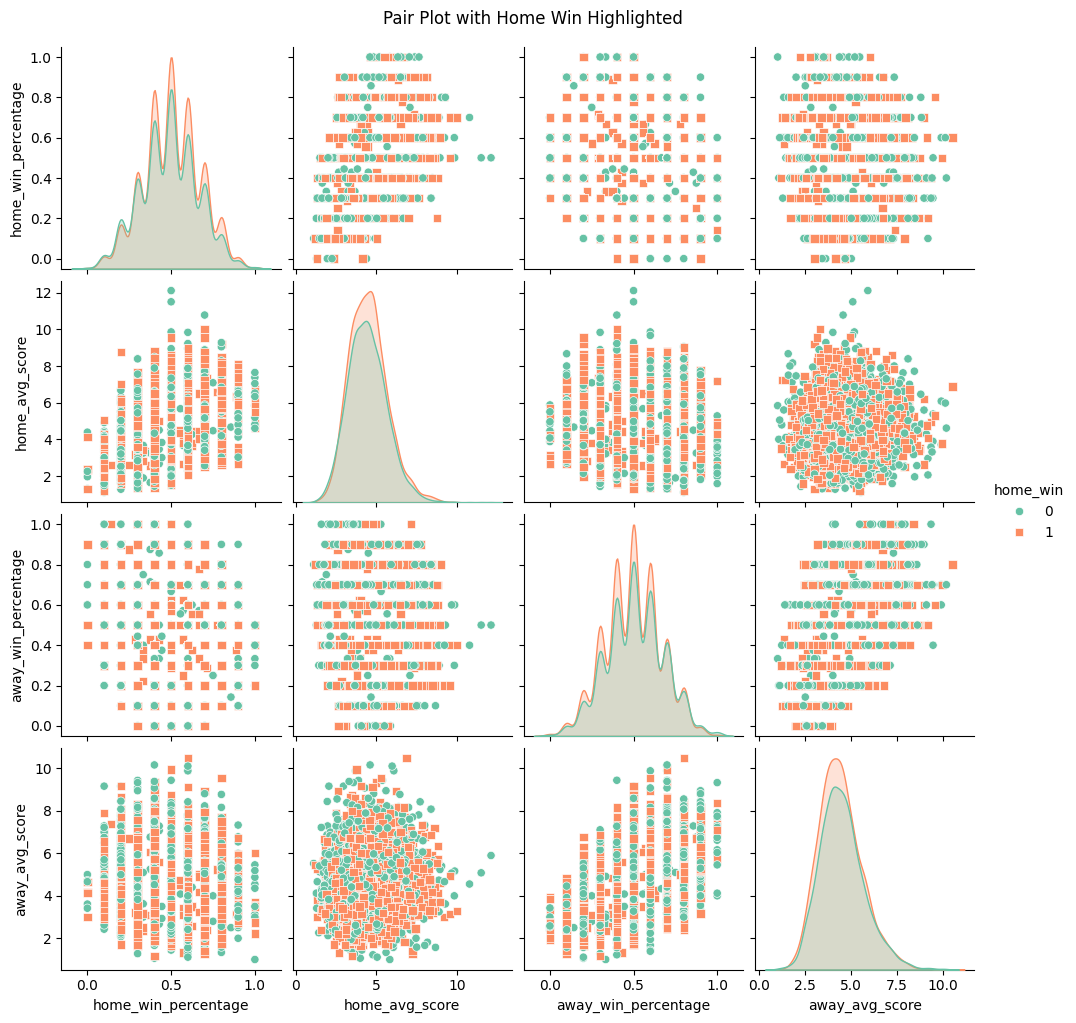

In [ ]:
# Select relevant features and add the target variable
features = ['home_win_percentage', 'home_avg_score', 'away_win_percentage', 'away_avg_score', 'home_win']
pairplot_data = df[features]

# Pair plot with hue for 'home_win'
sns.pairplot(pairplot_data, hue='home_win', diag_kind='kde', palette='Set2', markers=['o', 's'])
plt.suptitle('Pair Plot with Home Win Highlighted', y=1.02)
plt.show()

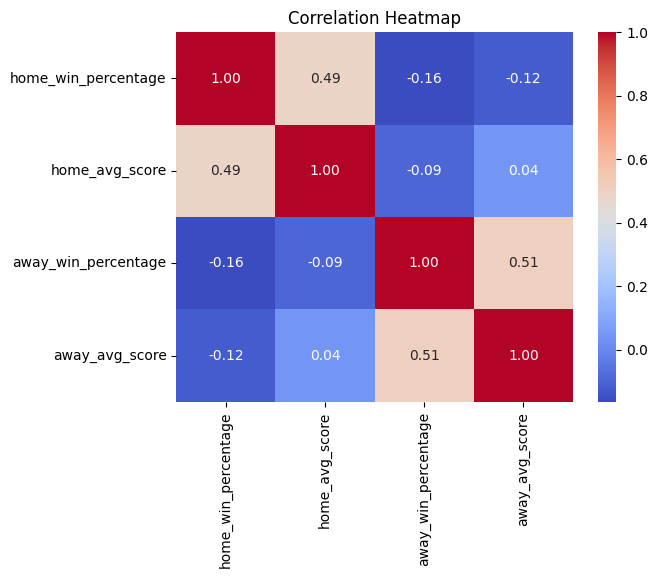

In [ ]:
# Correlation heatmap
correlation_matrix = df[['home_win_percentage', 'home_avg_score', 'away_win_percentage', 'away_avg_score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()